In [183]:
import numpy as np;
import scipy.optimize as scop;
from functools import partial;
import matplotlib.pyplot as plt;
import numpy.linalg as nalg;


# Almgren Chris discrete framework


## 1 Dimension 

We have X shares of an asset at $t_{0} = 0$
We want everything to be sold at t = T
We split [0;T] into N intervals of length $\tau = T=N$ 
and set
$t_{k} = k \tau$ , $k = 0,1,...,N$.

A trading strategy is a vector $x_{0}$,..,$x_{N}$, with $x_{k}$ the
number of shares we still have at time $t_{k}$.

$x_{0} = X$, $x_{N} = 0$ , and $n_{k} = x_{k} - x_{k-1}$ is the number of assets sold between $t_{k-1}$ and $t_{k}$ decided at $t_{k-1}$

Market impact => new price equilibrium at each time 

$S_{k} = S_{k-1} + \sigma  \tau^{\frac{1}{2}} \xi_{k} - \tau g(n_{k}/\tau)$
where $\xi_{k}$ are iid standard Gaussian.

Trading cost $C  = X S_{0} - \sum_{i=1}^{k} n_{k} \tilde{S_{k}}$
    $E[C]= \sum_{i=1}^{k} \tau x_{k} g(n_{k}/\tau) + \sum_{i=1}^{k} n_{k} h(n_{k}/\tau)$ 
    $Var[C] = \sigma^{2} \sum_{k=1}^{N} \tau x_{k}^{2}$
    
 
We want to minimize $E[C] + \lambda Var[C]$ where $\lambda$ is risk aversion parameter

Take permanent impact $g(v) = \gamma v$ 
Affine temporary impact $h(n_{k}/\tau) = \epsilon + \theta(n_{k}\tau)$ ( $\epsilon$ = fees + spread bid-ask  = 0 in our model)
Let $\tilde{\theta} = \theta - 0.5 \gamma \tau$ 

Our cost to minimize is equal to ( $\epsilon = 0$) 
    $0.5  \gamma X^{2} + \frac{\tilde{\theta}}{\tau}\sum_{k=1}^{N}(x_{k-1}-x_{k})^{2} + \lambda \sigma^{2} \sum_{k=1}^{N} \tau x_{k}^{2}$
    
Solution is given by:

For $j = 1, ..., N$, $x_{j} = \frac{sinh(K(T-t_{j})}{sinh(KT)} X $

where K is the solution to $\frac{2}{\tau^{2}}(cosh(K\tau) -1) = \tilde{K}$ 
          



In [141]:
def K_function(x,tau,K_tilde):
    return (np.cosh(x * tau )-1) - K_tilde * tau **2.

def K_inversion(tau,K_tilde):
    K_mini = partial(partial(K_function,tau),K_tilde);
    sol = scop.root_scalar(K_mini, bracket=[0, 3], method='brentq')
    return sol.root


In [142]:
class Liquidation_strategy : 
    def __init__(self,T,N,volatility,risk_aversion,theta,linear_impact_rate,X):
        self.T = T;
        self.N = N;
        self.theta = theta;
        self.Initial_parts = X;
        self.volatility = volatility;
        self.risk_aversion = risk_aversion;
        self.linear_impact_rate = linear_impact_rate;
 
    def Parts_to_liquidate(self):
        List_parts = [];
        X = self.Initial_parts;
        List_parts.append(X);
        tau = self.T/self.N;
        theta_tilde = self.theta - 0.5 * self.linear_impact_rate* tau;
        if (self.linear_impact_rate != 0):
            K_tilde = self.risk_aversion * (self.volatility) ** 2. / theta_tilde;
            K = K_inversion(tau,K_tilde);
        else:
            K = 0.;
            for i in range(1,self.N):
                List_parts.append( X/self.N );
            return List_parts;
        
        for i in range(1,self.N):
                List_parts.append( 2 * np.sinh(K*tau*0.5)/np.sinh(K*self.T)*np.cosh(K*(self.T - i * tau + tau/2)) * X )
        return List_parts;

    


In [149]:
L = Liquidation_strategy(6,6,0.2,10,0.2,1.,1e3)
M = L.Parts_to_liquidate();

In [150]:
M

[1000.0,
 440.50181688021985,
 247.9059919333485,
 140.6467426290368,
 81.80226255898087,
 51.116541025401986]

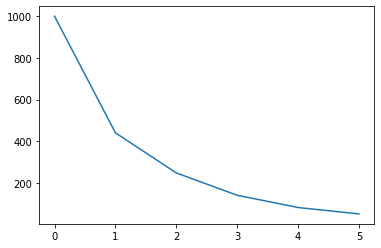

In [151]:
plt.plot([i for i in range(0,6)],M)
plt.show()

## Multi dimensional framework
### ( d = 3 case only for the example)


$S_{k}$ now follows a multidimensional arithmetic brownian motion random walk with zero drift.
Let $\xi_{k} = (\xi_{1k},....,\xi_{rk})^{T}$ be a vector of $r \leq m$ independant Brownian increments, with $\sigma$ a $m \times r$ additive volatility matrix. $S2 = \sigma \sigma^{T}$ symetric positive definite variance-covariance matrix

Permantent impact $g(v) = \Gamma v$
Affine temporary impact $h(v) = \epsilon \times sgn(v) + H v $

$\Gamma$ and $H$  $m \times m$ matrix, $\epsilon m \times 1$ column ( Again we suppose here $\epsilon \equiv 0$)

$E[C] = 0.5 * X^{T} \gamma^{S} X + \sum_{k=1}^{N} \tau v_{k}^{T}\tilde{H}v_{k} + \sum_{k=1}^{N} \tau x_{k}^{T} \gamma^{A}v_{k}$
$V[C] = \sum_{k=1}^{N} \tau x_{k}^{T} S2 x_{k}$

$\tilde{H} = H^{S} - 0.5 * \Gamma^{S}$
$H^{S} = 0.5 ( H + H^{T})$ 
$H^{A} = H - H^{S} $

By denoting $y_{k} = \tilde{H}^{0.5} x_{k}$ we obtain the following equation solving the minimization problem

$\frac{y_{k-1} - 2 y_{k} + y_{k+1}}{\tau^{2}} = \lambda A y_{k} + B \frac{ y_{k-1} - y_{k+1}}{2\tau}$
where $A = \tilde{H}^{-0.5} S2 \tilde{H}^{0.5}$  and  $B = \tilde{H}^{-0.5} \Gamma^{A} \tilde{H}^{0.5}$
We obtain a (N-1)m linear system we can solve


Indeed we have $( A - \frac{2}{\tau^{2}}) y_{k} + ( 1 + \frac{2}{\tau} B) y_{k+1} + (1 - \frac{2}{\tau} B) y_{k-1}$ = 0
We know the first value 0 $y_{0} = \tilde{H}^{0.5} x_{0} = \tilde{H}^{0.5} X$.
Then by denoting $Y = (y1,....,y_{N})^{T}$ we end up on a linear system with a laplacian form of matrix composed of $m \times m$ matrix.


In [314]:

def remplir(M,N,A,B,tau):
    E = ( A - 2/tau**2 * np.identity(M))
    F = ( B/(2 * tau) + np.identity(M))
    D = ( B/(2*tau) - np.identity(M))
    O = np.zeros((M,M));
    return np.block([[E,F,O,O,O,O],[D,E,F,O,O,O],[O,D,E,F,O,O],[O,O,D,E,F,O],[O,O,O,D,E,F],[O,O,O,O,D,E]]);

class Liquidation_strategy_m : 
    def __init__(self,m,T,N,volatility,H,risk_aversion,theta,linear_impact_rate,X_m):
        self.T = T;
        self.N = N;
        self.m = m;
        self.theta = theta;
        self.H = H;
        self.Initial_parts = X_m;
        self.volatility = volatility;
        self.risk_aversion = risk_aversion;
        self.linear_impact_rate = linear_impact_rate;
        self.X_m = X_m;
    
    def Parts_to_liquidate(self):
        N = self.N;
        tau = self.T/self.N;
        S2 = self.volatility.dot(self.volatility);
        H_S = 0.5 * ( self.H + (self.H).T)
        Gamma = self.linear_impact_rate;
        Gamma_S = 0.5 * ( Gamma + Gamma.T)
        H_tilde = H_S - 0.5 * tau * Gamma_S;
        H_tilde_sqrt = np.sqrt(H_tilde);
        H_tilde_sqrt_inv = nalg.inv(H_tilde_sqrt);
        A = H_tilde_sqrt_inv  * S2 * H_tilde_sqrt_inv 
        B = H_tilde_sqrt_inv  * ( Gamma - Gamma_S) * H_tilde_sqrt_inv 
        y_0 = np.dot(H_tilde_sqrt,self.X_m.T);
        m = self.m;
        Y_vector = np.zeros((N* m ,1));
        X_sol = np.zeros((N*m,1));
        R = remplir(m,N,A,B,tau);
        Y_vector[0:m] = - np.dot(( np.identity(m) - 2/tau *B),y_0) ;
        print(Y_vector);
        Y_sol = nalg.solve(R, Y_vector);
        for i in range(0,self.T):
            X_sol[m*i:m*(i+1)] = np.dot(nalg.inv(H_tilde_sqrt),Y_sol[m*i:m*(i+1)])
        return X_sol;
            


In [315]:
m = 4 ;
T = 6;
N = 6;
volatility = 0.2 * np.identity(m);
H = 0.3 * np.identity(m);
risk_aversion =  3.;
theta = 2.;
linear_impact_rate = 1e-3 * np.identity(m);
X_m = np.array([[1e3,2e3,3e3,4e3]])


L = Liquidation_strategy_m(m,T,N,volatility,H,risk_aversion,theta,linear_impact_rate,X_m);

In [316]:
L.Parts_to_liquidate()

[[ -547.2659317]
 [-1094.5318634]
 [-1641.7977951]
 [-2189.0637268]
 [    0.       ]
 [    0.       ]
 [    0.       ]
 [    0.       ]
 [    0.       ]
 [    0.       ]
 [    0.       ]
 [    0.       ]
 [    0.       ]
 [    0.       ]
 [    0.       ]
 [    0.       ]
 [    0.       ]
 [    0.       ]
 [    0.       ]
 [    0.       ]
 [    0.       ]
 [    0.       ]
 [    0.       ]
 [    0.       ]]


array([[ 434.56421163],
       [ 869.12842327],
       [1303.6926349 ],
       [1738.25684653],
       [-188.91020266],
       [-377.82040532],
       [-566.73060799],
       [-755.64081065],
       [  81.97388346],
       [ 163.94776692],
       [ 245.92165038],
       [ 327.89553383],
       [ -35.9105337 ],
       [ -71.82106741],
       [-107.73160111],
       [-143.64213481],
       [  14.94888065],
       [  29.89776131],
       [  44.84664196],
       [  59.79552262],
       [  -8.009284  ],
       [ -16.018568  ],
       [ -24.027852  ],
       [ -32.037136  ]])